## Robot Learning

## Assignment 7

#### Group names: Edit this cell and write your names here

### Introduction

On this assignment sheet, we will use two environments from [OpenAi Gym](https://gym.openai.com/). You already know the first one, it is almost equivalent to the Blackjack environment from the previous assignment sheet. The second one is much more complicated, and requires installation of some further packages. Since this installation is not trivial, and we could only test it in our setup, we strongly recommend that you execute the cells in this notebook in [Google Colab](https://research.google.com/colaboratory/). You should find a button which opens this file directly in Colab at the top of this notebook. If not, you can simply import the .ipynb manually. 

If you have started your Colab session and are ready to proceed, uncomment the two lines in the code cell below. They will install everything required to simulate the Gym environments. Note that these are only necessary for the final programming task. For the first one, you need only gym without any further addons. This can be obtained by executing *conda install -c conda-forge gym* in your terminal when the *rl_env* is active.

**Warning: This is unlikely to work on your own computer, and might even mess up your system! Please only use the following lines in Colab. If you insist on using your own machine, please refer to installation instructions for Gym, torch and the box2d environments for your system.**

In [1]:
!apt-get -qq install python-opengl xvfb x11-utils &> /dev/null
!pip install box2d-py pyvirtualdisplay moviepy pyglet PyOpenGL-accelerate --quiet &> /dev/null

The following cell imports packages required for the task. 

In [2]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from pyvirtualdisplay import Display
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
import torch
import torch.nn as nn
from tqdm import tqdm

In [17]:
import pandas as pd
import seaborn as sns

### Task 28

Your agent is in state $s_t$ and has the $Q$-values $Q(s_t,a) = [Q(s_t,a_0), Q(s_t,a_1), Q(s_t,a_2), Q(s_t,a_3)] = [5, 1, 2, 8]$. If the agent samples its action according to a probabilistic policy $\pi(s_t,a)$ which is created by softmax action selection from $Q(s_t,a)$, then what is the probability $Pr(a_3 | s_t)$ of taking action $a_3$ in state $s_t$?

<div style="text-align: right; font-weight:bold"> 4 Points </div>

Please answer here.
exp(8) / (exp(5) + exp(1) + exp(2) + exp(8))



### Task 29

Please examine the contents of the code cell below, where an agent following the random uniform policy plays Blackjack. The agent-environment interaction is equivalent to the one on Assignment 06, but the environment is loaded from Gym this time.

In [ ]:
# create the environmentment
casino = gym.make('Blackjack-v0')

# reset the environment
s = casino.reset()
# state is (player sum, dealer sum, usable_ace)
# convert the state, such that the bool usable_ace can index numpy arrays
s = (s[0], s[1], int(s[2]))
done = 0
while not done:
    # select random action
    a = casino.action_space.sample()
    # execute random action
    s_prime, r, done, _ = casino.step(a)
    # convert s_prime such that usable_ace is int
    s_prime = (s_prime[0], s_prime[1], int(s_prime[2]))
  

In [ ]:
# create the environmentment
casino = gym.make('Blackjack-v0')

# reset the environment
s = casino.reset()
# state is (player sum, dealer sum, usable_ace)
# convert the state, such that the bool usable_ace can index numpy arrays
s = (s[0], s[1], int(s[2]))
done = 0
while not done:
    # select random action
    a = casino.action_space.sample()
    print(a)
    # execute random action
    s_prime, r, done, _ = casino.step(a)
    # convert s_prime such that usable_ace is int
    s_prime = (s_prime[0], s_prime[1], int(s_prime[2]))
    s = s_prime

1
1
1


Implement the actor-critic version of TD(0) control. You can proceed as described on slide 50 in lecture 06. However, please adjust the update of the preferences p(s,a) to

$$p[s_t][a_t] \leftarrow p[s_t][a_t] + \beta \delta_t [1 - \pi(s,a_t)]$$

This represents the learning rule for the actor. For the critic, you can update state values $V(s_t)$ according to

$$V(s_t) \leftarrow V(s_t) + \alpha \delta_t$$ 

after updating the actor for each step of the episode. Use $\alpha = \beta = 0.2$ and $\gamma = 0.9$ and learn for 1 million episodes (should take less than 5 minutes). 

<div style="text-align: right; font-weight:bold"> 8 Points </div>

In [ ]:
def pickAction(P,s):
  
  weights = np.exp(P[s[0],s[1],s[2],:])

  probs = weights / np.sum(weights)

  return np.random.choice([0,1], p=probs)


In [ ]:
# plays numIter episodes of game by greedily following Q
# returns average return
def evaluateP(game,P,numIter):
    accumulatedReward = 0.
    for episode in range(numIter):
        s = game.reset()
        s = (s[0],s[1],int(s[2]))
        done = 0
        while not done:
            a = pickAction(P,s)
            s_prime, r, done, _ = game.step(a)
            accumulatedReward += r
            s = (s_prime[0], s_prime[1], int(s_prime[2]))
    return accumulatedReward/numIter

In [ ]:
def actor_critic_TD_0(game,alpha=0.2,beta=0.2,gamma=0.9,noOfEpisodes=10000,eval_every=None,test_eval=None):

  V = np.zeros((32,11,2))
  P = np.zeros((32,11,2,2))

  periodic_ep_returns = []
  test_ep_returns = []
  periodic_reward_sum = 0

  for epoch in range(1,noOfEpisodes+1):

      #reset environment
    s = game.reset()
    s = (s[0], s[1], int(s[2]))
    done = 0
    episodeReward = 0

    while not done:
      
      #print(P.shape)
      #print(P)
      #print(s)
      a = pickAction(P,s)

      s_prime, r, done, _ = game.step(a)

      s_prime = (s_prime[0], s_prime[1], int(s_prime[2]))
      episodeReward += r

      #Td error
      delta = r + gamma*V[s_prime] - V[s]

      #p-update
      pi = np.exp(P[s[0],s[1],s[2],a]) / np.sum(np.exp(P[s[0],s[1],s[2],:]))
      P[s[0],s[1],s[2],a] += beta*delta*(1 - pi)

      #Critic update
      V[s] += alpha * delta

      s = s_prime
    
    periodic_reward_sum += episodeReward
    if eval_every is not None:
      if epoch % eval_every == 0:
        periodic_ep_returns.append(periodic_reward_sum / eval_every)
        periodic_reward_sum = 0
        if test_eval is not None:
          test_ep_returns.append(evaluateP(game,P,test_eval))



  if eval_every is None:
    return P
  elif test_eval is None:
    return P, periodic_ep_returns
  else:
    return P,periodic_ep_returns,test_ep_returns
      


In [ ]:
eval_every = 10000
test_eval=1000

In [ ]:
P,ep_returns,test_ep_returns = actor_critic_TD_0(game=casino,alpha=0.2,beta=0.2,gamma=0.9,noOfEpisodes=1000000,eval_every=10000,test_eval=1000)

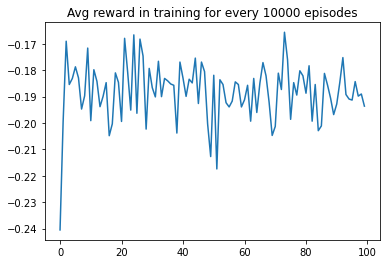

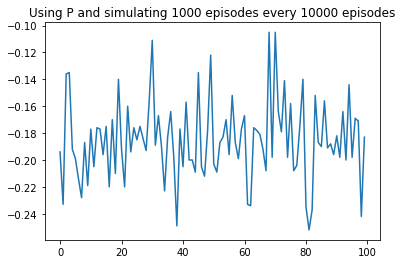

In [ ]:
plt.plot(range(len(ep_returns)),ep_returns)
plt.title(f"Avg reward in training for every {eval_every} episodes")
plt.show()
plt.plot(range(len(test_ep_returns)),test_ep_returns)
plt.title(f"Using P and simulating {test_eval} episodes every {eval_every} episodes")
plt.show()

Then, visualize the greedy version of the policy induced by $p$. You can draw on the example presented in the tutorial for assignment 06 for inspiration (and code) in this regard. 

<div style="text-align: right; font-weight:bold"> 4 Points </div>

In [ ]:
# helper function to pretty-print policy, black is hit, white is stick
#Greedily pick action with better p value (while training we chose based on softmax)
def plotPolicy(Q):    
    fig, (ax1, ax2) = plt.subplots(1,2, constrained_layout=True)#figsize=(10,5),
    policy = np.argmax(Q[12:22,1:,1,:],axis = 2)
    cax1 = ax1.matshow(policy, cmap = 'Greys',origin='lower', aspect="auto")
    xticks = np.arange(0,10,1)
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(['A']+["{}".format(int(x)+1) for x in np.arange(1,10,1)])
    ax1.set_xlabel("Dealer showing")
    
    yticks = np.arange(0,10,1)
    ax1.set_yticks(yticks)
    ax1.set_yticklabels(["{}".format(int(x)+11) for x in yticks])
    ax1.set_ylabel("Player sum")
    
    ax1.set_title('Usable Ace')
    ax1.yaxis.tick_right()
    ax1.yaxis.set_label_position("right")
    ax1.xaxis.tick_bottom()
    
    
    policy = np.argmax(Q[4:22,1:,0,:],axis = 2)
    cax2 = ax2.matshow(policy, cmap = 'Greys',origin='lower', aspect="auto")
    xticks = np.arange(0,10,1)
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(['A']+["{}".format(int(x)+1) for x in np.arange(1,10,1)])
    ax2.set_xlabel("Dealer showing")
    
    yticks = np.arange(0,18,1)
    ax2.set_yticks(yticks)
    ax2.set_yticklabels(["{}".format(int(x)+3) for x in yticks])
    ax2.set_ylabel("Player sum")
    
    ax2.set_title('No Usable Ace')
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    ax2.xaxis.tick_bottom()
    plt.show()

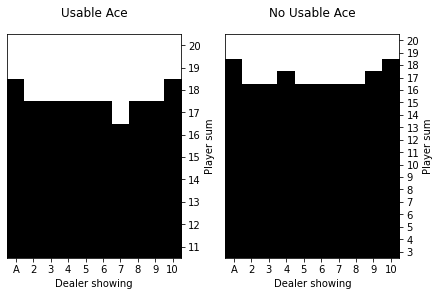

In [ ]:
plotPolicy(P)

In [ ]:
from matplotlib.pyplot import figure
def visualizeActions(Q,s2): #We fix no of usable aces as s2
    
    optimalActions = []  #optimalActions[s0,s1,a] = 0 implies for state (s0,s1,s2) 0 is best action
    for s0 in range(32):
        for s1 in range(11):
            if Q[s0,s1,s2,0] == Q[s0,s1,s2,1]:
                a = 1 #Neutral action
            else:
                a = 2*np.argmax(Q[s0,s1,s2,:])
            optimalActions.append([s0,s1,a])

    optimalActionsDf = pd.DataFrame(optimalActions, columns=['MyHand', 'DealerCard', 'Action'])
    figure(figsize=(8, 6), dpi=80)
    plt.title("No usable Aces")
    sns.scatterplot(data=optimalActionsDf,x="MyHand",y="DealerCard",hue = "Action",palette = ['blue','green','red'])
    plt.show()

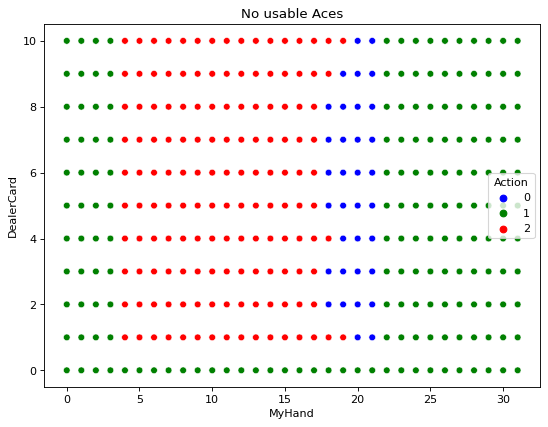

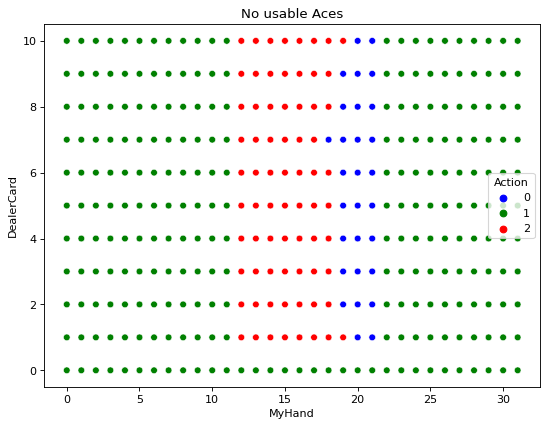

In [ ]:
#Plotting actions

#For no of usable aces = 0
visualizeActions(P,0)

#For no of usable aces = 1
visualizeActions(P,1)


### Task 30

In this task, we will combine an actor-critic method like above with a policy gradient algorithm to control an agent in a more challenging environment: the Lunar Lander. 

In [3]:
# set up showing animations from the environment in Colab.
Display(visible=False).start()

Examine the code cell below. It has two distinct purposes:

* Showcase the agent-environment interaction for LunarLander-v2

* Show how you can capture frames from this environment to animate an episode afterwards.

Note that for training an agent in this environment, it is advisable to omit all code corresponding to the rendering. You can seperately render an episode of your agent's play afterwards.


In [4]:
# Name of the environment, if you are having problems you can switch to 'CartPole-v1', which is easier to solve.
ENV_NAME = 'LunarLander-v2' # 'CartPole-v1'
# Dimension of the LunarLander state space. For 'CartPole-v1', use 4 instead
ENV_STATE_DIM = 8 # 4
# Lunar Lander has 4 discrete actions: [Do Nothing, Fire Left Booster, Fire Main Engine, Fire Right Booster], 'CartPole-v1' has 2
ENV_ACTION_DIM = 4 # 2
# create the environment
env = gym.make(ENV_NAME)
# reset the environment
state = env.reset() # state = [x, y, dx, dy, theta, dtheta, leg1_contact, leg2_contact]
# track whether the episode is over
done = False
# list to append the frames produced by the environment renderer
frames = []
while not done:
  # render current situation and append to frames
  frames.append(env.render('rgb_array'))
  # select a random action
  action = env.action_space.sample()
  # execute this action
  state, reward, done, info = env.step(action)
# print the number of frames
print('Number of frames:', len(frames))
# prevent the renderer from showing artifacts
plt.close()

Number of frames: 66


In [7]:
# helper function to animate a list of frames as produced above
def visualize_trajectory(frames, fps=50):
  duration = int(len(frames) // fps + 1)
  fig, ax = plt.subplots()
  def make_frame(t, ind_max=len(frames)):
      ax.clear()
      ax.imshow(frames[min((int(fps*t),ind_max-1))])
      return mplfig_to_npimage(fig)
  plt.close()
  return VideoClip(make_frame, duration=duration)

In [8]:
# get the animation from the frames of the played episode
animation = visualize_trajectory(frames)
# show the animation
animation.ipython_display(fps=50, loop=True, autoplay=True)

 99%|█████████▉| 100/101 [00:07<00:00, 13.96it/s]


Probably, the random agent will destroy itself instead of landing between the two flags. We would like you to improve upon this. Below, you are given a neural net with learnable weights $\theta$ which takes an environment state $s_t$ as input and can output either a state value $V_{\theta}(s_t)$ or a probability distribution over the actions $\pi_{\theta}(s_t,a)$. 

In [9]:
# If you feel like it, you can, but you do not need to adapt this
class DualNet(nn.Module):
    def __init__(self, state_dim=ENV_STATE_DIM, action_dim=ENV_ACTION_DIM, hidden_layer_dim=42):
        super(DualNet, self).__init__()
        # create some layers to encode the input state
        self.layers = [nn.Linear(state_dim, hidden_layer_dim),
                       nn.PReLU(num_parameters=hidden_layer_dim)]
        # combine these layers into a net
        self.net = nn.Sequential(*self.layers)
        # critic output layers to estimate V from the state encoding
        self.critic = nn.Sequential(*[nn.Linear(hidden_layer_dim,1)])
        # actor output layers to estimate pi from the state encoding
        self.actor = nn.Sequential(*[nn.Linear(hidden_layer_dim,action_dim),
                                        nn.Softmax(dim=-1)])
    def forward(self, s, mode):
        # convert input state to tensor
        x = torch.tensor(s).float().view(1,-1)
        # encode state
        x = self.net(x)
        if mode == 'actor':
          # return probability distribution over actions
          x = self.actor(x)
        else:
          # return estimate of state value
          x = self.critic(x)
        return x.squeeze()

# example usage:
# create instance of the DualNet class
test_net = DualNet()
# create a dummy state, round just for pretty printing
test_input = np.around(np.random.rand(ENV_STATE_DIM),2)
# get the actor output
actor_out = test_net(test_input, mode='actor')
# get the critic output
critic_out = test_net(test_input, mode='critic')
print('Dummy Input:', test_input)
print('Actor output:', actor_out)
print('Critic output:', critic_out)

Dummy Input: [0.52 0.78 0.44 0.35 0.36 0.88 0.13 0.12]
Actor output: tensor([0.2186, 0.2369, 0.2918, 0.2526], grad_fn=<SqueezeBackward0>)
Critic output: tensor(-0.1780, grad_fn=<SqueezeBackward0>)


Now to the task: Play episodes according to the following scheme:

* For each visited state $s_t$, store the output of the critic $V_\theta(s_t)$ in a list.

* Select an action $a_t$ by sampling from the distribution $\pi_{\theta}(s_t,a)$ output by the actor. In a list, store the log prob of the action: $l_t = log(\pi_{\theta}[s_t,a_t])$. 

* Execute the action and observe the reward $r_{t+1}$ provided by the environment.

After each episode, use the stored rewards to calculate the Returns $R_t$ following each state $s_t$ using the discount factor $\gamma$. Next, calculate for each $t$

$$\delta_t = R_t - V_{\theta}(s_t)$$

Then, calculate the loss of the critic as

$$L_{critic} = 0.5 \sum_t \delta_t^2$$

and the loss of the actor using the log probs as

$$L_{actor} = \sum_t - l_t  \delta_t$$

and finally the total loss

$$L = L_{critic} + L_{actor}$$

Now, update the parameters $\theta$ using

$$\theta \leftarrow \theta + \alpha \nabla_{\theta}L$$

The Lunar Lander problem is considered solved when the agent achieves an average return of 200 over 100 episodes. Solve the problem, or play around 3000 episodes as described above and then report the average return of the final 100 episodes played. This means that you are welcome to preemptively stop training if the average return is sufficient. Then, play one more episode and animate it like in the example above. Use $\gamma = 0.99$, and $\alpha \approx 0.001$ in your experiments. Save your final animation and place it into your sciebo folder along with this notebook. When we tested this in our colab session, the environment was solved after around 1500 steps, taking around 10 minutes of training time. We used a learning rate of $0.005$, but please note that this parameter might be sensitive to the specifics of your implementation.

<div style="text-align: right; font-weight:bold"> 4 Points </div>

### Hints:

Following tips might help you complete this task:

* You might need to convert your return $R_t$ to the correct datatype:

$$\delta_t = torch.tensor(R_t) - V_{\theta}(s_t)$$

* If you want to use numpy to sample from $\pi_{\theta}(s_t,a)$, you can get a numpy array by calling 

$$\pi_{\theta}(s_t,a).detach().numpy()$$

* When you calculate the log probs $l_t$, preserve the torch gradient graph by using the torch function

$$l_t = torch.log(\pi_{\theta}[s_t,a_t])$$

* When you calculate $L_{actor}$, use $\delta_t.item()$ to ensure that the actor's loss does not directly influence the critic's gradients.

* It might be easier to solve the task for the Cart-Pole environment first, just change ENV_NAME, ENV_STATE_DIM and ENV_ACTION_DIM in one of the previous code blocks. 

* Standardizing the Returns (zero mean and std 1) before calculating $\delta_t$ can boost performance.

* Below you are already given a rough structure for the algorithm. If you stick to it, torch will compute and apply $\nabla_{\theta}L$ for you!

This task is very difficult. Points will be given also for partial solutions.


In [10]:
# Complete this code or write your own!
# Create the environment
env = gym.make(ENV_NAME)
# Get the combined actor and critic model
net = DualNet()
# Number of episodes to play, maybe use fewer at first
num_iter = 2500
#num_iter = 1000
# Learning rate for the parameter updates
alpha = 0.005
# Discount factor
gamma = 0.99

winning_return = 200
episodes_to_win = 100

no_of_cont_wins = 0
discounted_ep_returns = []
ep_returns = []

#Find the average return of of last eval_every episodes of training
avg_episode_returns = []
eval_every = 100 

# The optimizer will do the gradient updates for you
# It needs the trainable parameters and a learning rate
optimizer = torch.optim.Adam(net.parameters(), lr=alpha)

# This progress_bar is useful to know how far along the training is
progress_bar = tqdm(range(num_iter), total=num_iter, position=0, leave=True)
# For each episode (episode can be used like an int)
for episode in progress_bar:
    # Reset the accumulated gradients of the model parameters
    optimizer.zero_grad()
    # Reset the environment and observe the starting state
    s = env.reset()
    done = 0
    # Collect the following terms during the episode
    rewards = []
    state_vals = []
    log_probs = []
    ep_return = 0
    while not done:
        # During each Episode:
        # Evaluate the critic for s, store it
        # get the critic output
        critic_out = net(s, mode='critic')
        state_vals.append(critic_out)

        # Evaluate the actor for s
        actor_out = net(s, mode='actor')

        # Sample a from the distribution given by the actor
        probs = actor_out.detach().numpy()

        a = np.random.choice(ENV_ACTION_DIM, p=probs)
        
        # Store log_prob of a
        log_probs.append(torch.log(actor_out[a]))

        # Execute action a, observe next state, reward and done
        s, r, done, _ = env.step(a)
        # Store the reward
        rewards.append(r)
        ep_return += r

    # After each episode is done
    # Calculate the Returns from the episode. Use rewards and gamma
    rewards = np.array(rewards)

    discount_arr = np.logspace(0,len(rewards),endpoint=False,base=gamma,num=len(rewards))
    discount_returns = [np.sum(discount_arr[:len(rewards)-t] * rewards[t:]) for t in range(len(rewards))]
    discount_returns = np.array(discount_returns)

    if ep_return > winning_return:
        no_of_cont_wins+=1
    else:
        no_of_cont_wins = 0


    ep_returns.append(ep_return)
    discounted_ep_returns.append(discount_returns[0])

    if episode>eval_every:
        avg_episode_return = np.mean(ep_returns[-eval_every:])
        avg_episode_returns.append(avg_episode_return)


    # You might want to standardize the Returns
    returns = (discount_returns - np.mean(discount_returns)) / np.std(discount_returns)


    # Calculate delta_t
    '''deltas = []
    for t in range(len(state_vals)):
        deltas.append(torch.tensor(returns[t]) - state_vals[t])'''

    deltas = torch.tensor(returns) - torch.tensor(state_vals)

    # Calculate L_actor
    L_actor = torch.tensor(0.0)
    for t in range(len(deltas)):
        L_actor += 0.5 * (deltas[t].item() * deltas[t].item())
    
    #L_actor = torch.tensor(0.5 * np.sum((np.array(deltas.tolist()))**2))

    # Calculate L_critic
    L_critic = torch.tensor(0.0)
    for t in range(len(deltas)):
        L_critic += -1 * log_probs[t] * deltas[t]

    #L_critic = torch.sum( -1 * torch.tensor(log_probs) * deltas)

    # Calculate the loss L
    L = L_critic + L_actor
    # Set the gradients with respect to the parameters
    L.backward()
    # Update the parameters based on the gradients
    optimizer.step()
    # If you want your progress bar to print info, you can use the following template
    # How often to update info
 
    if episode % 10 == 0:
      # When to first update info
      if episode > eval_every:
        # List of strings containing info
        episode_summary = [f"{episode+1}: "] + [f'Avg return for past {eval_every} episodes: {avg_episode_return}|| ',f'Episode return: {ep_return}|| ' ,f'No of cont wins: {no_of_cont_wins}' ]
        # Set progress bar
        progress_bar.set_description("".join(episode_summary))

2491: Avg return for past 100 episodes: 250.6001599931481|| Episode return: 284.2973424445263|| No of cont wins: 25: 100%|██████████| 2500/2500 [16:26<00:00,  2.54it/s]


Model takes about 20 mins to train using colabs gpu

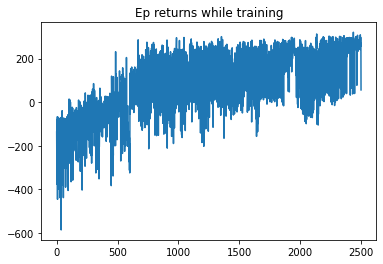

In [15]:
# Your code for showing the results here!
plt.title("Ep returns while training")
plt.plot(range((len(ep_returns))),ep_returns)

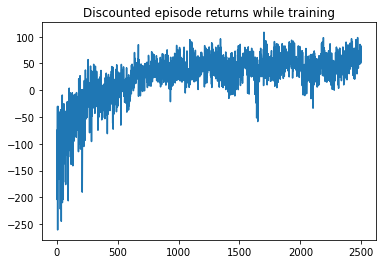

In [16]:
plt.title("Discounted episode returns while training")
plt.plot(range((len(discounted_ep_returns))),discounted_ep_returns)

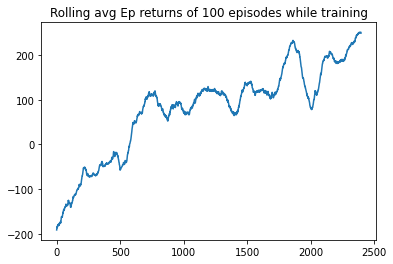

In [17]:
plt.title(f"Rolling avg Ep returns of {eval_every} episodes while training")
plt.plot(range((len(avg_episode_returns))),avg_episode_returns)

In [18]:
np.mean(ep_returns[-100:])

249.31616660408392

In [22]:
ENV_NAME = 'LunarLander-v2' # 'CartPole-v1'
# Dimension of the LunarLander state space. For 'CartPole-v1', use 4 instead
ENV_STATE_DIM = 8 # 4
# Lunar Lander has 4 discrete actions: [Do Nothing, Fire Left Booster, Fire Main Engine, Fire Right Booster], 'CartPole-v1' has 2
ENV_ACTION_DIM = 4 # 2
# create the environment
env = gym.make(ENV_NAME)
# reset the environment
state = env.reset() # state = [x, y, dx, dy, theta, dtheta, leg1_contact, leg2_contact]
# track whether the episode is over
done = False
# list to append the frames produced by the environment renderer
frames = []
while not done:
    # render current situation and append to frames
    frames.append(env.render('rgb_array'))

    actor_out = net(state, mode='actor')
    # Sample a from the distribution given by the actor
    probs = actor_out.detach().numpy()
    action = np.random.choice(ENV_ACTION_DIM, p=probs)
    
    # execute this action
    state, reward, done, info = env.step(action)
    # print the number of frames
print('Number of frames:', len(frames))
# prevent the renderer from showing artifacts
plt.close()

Number of frames: 246


In [23]:
# get the animation from the frames of the played episode
animation = visualize_trajectory(frames)
# show the animation
animation.ipython_display(fps=50, loop=True, autoplay=True)

100%|█████████▉| 250/251 [00:18<00:00, 13.89it/s]


In [24]:
animation.write_videofile("Lunar_Lander_final.mp4",fps=50)

[MoviePy] >>>> Building video Lunar_Lander_final.mp4
[MoviePy] Writing video Lunar_Lander_final.mp4


100%|█████████▉| 250/251 [00:18<00:00, 13.50it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: Lunar_Lander_final.mp4 

